In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/WGCNA_MEA_correlation")

In [25]:
library(ggplot2)
library(ggrepel)
library(WGCNA)
library(tidyverse)
library(CorLevelPlot)
library(gridExtra)
library(gprofiler2)
library(ggpubr)
library(reshape2)
library(openxlsx)
library(pheatmap)

In [ ]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq")

In [13]:
mea_traits<-read.csv('T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/patients_normalized_hier_PC13.csv')
mea_traits<-mea_traits[-1]
mea_seq_samples<-mea_traits$sample
rownames(mea_traits)<-mea_traits$sample
mea_traits_noMeta <- mea_traits %>% dplyr::select(where(is.numeric))#mea_seq_samples<-rownames(mea_traits_noMeta)
#remove the hier clusterig variable
mea_traits_noMeta<-mea_traits_noMeta[-length(mea_traits_noMeta)]

In [4]:
samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample

In [9]:
module_eigengenes<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/WGCNA/module_eigengenes_NT_signed_sp16.csv")
rownames(module_eigengenes)<-module_eigengenes$X
module_eigengenes<-module_eigengenes[-1]
module_eigengenes_ex<-module_eigengenes[mea_seq_samples,]

In [15]:
# Define numbers of genes and samples
nModules <- ncol(module_eigengenes_ex)
nMetrics <- ncol(mea_traits_noMeta)
numb_of_traits=length(mea_traits_noMeta)
#module.trait.corr <- cor(module_eigengenes_ex, mea_traits_noMeta, use = 'p')#first see pearson, which is more "strict". No significant
module.trait.corr <- cor(module_eigengenes_ex, mea_traits_noMeta, method = 'spearman')
nModules
nMetrics

[1] 50

[1] 21

In [16]:
est_list<-list()
pval_list<-list()
for (i in 1:nMetrics){
    est <- c()
    p <- c()
    for (j in 1:nModules){
    s_corr<-cor.test(mea_traits_noMeta[[i]],module_eigengenes_ex[[j]],method = 'spearman',exact = FALSE)
    p_val<-s_corr$p.value
    estimate<-unname(s_corr$estimate)
     est[j]<- estimate  
     p[j]<- p_val  
    }
    est_list[[i]]<-est
    pval_list[[i]]<-p
    }
names(est_list)<-colnames(mea_traits_noMeta)
names(pval_list)<-colnames(mea_traits_noMeta)
est_list<-do.call(cbind,est_list)
pval_list<-do.call(cbind,pval_list)
rownames(est_list)<-colnames(module_eigengenes_ex)
rownames(pval_list)<-colnames(module_eigengenes_ex)
all_adj<-round(p.adjust(c(pval_list), method ="fdr", n = length(c(pval_list))),3)
all_adj<-split(all_adj,ceiling(seq_along(all_adj) / nModules))
all_adj<-as.data.frame(t(do.call(rbind, all_adj)))
rownames(all_adj)<-rownames(pval_list)
colnames(all_adj)<-colnames(pval_list)
all_adj<-as.matrix(all_adj)

In [21]:
# Create a new workbook
wb <- createWorkbook()

# Add worksheets
addWorksheet(wb, "WGCNA_MEA_variables_corr")
addWorksheet(wb, "WGCNA_MEA_variables_adj_p")

# Write data to the worksheets
writeData(wb, sheet = "WGCNA_MEA_variables_corr", est_list)
writeData(wb, sheet = "WGCNA_MEA_variables_adj_p", all_adj)

# Save workbook
saveWorkbook(wb, file = "WGCNA_MEA_correlations.xlsx", overwrite = TRUE)

In [23]:
#make a pheatmap
# --- 1. Generate matrix of asterisks based on p-values ---
sig_labels <- ifelse(all_adj <= 0.001, "***",
              ifelse(all_adj <= 0.01,  "**",
              ifelse(all_adj <= 0.05,  "*", "")))

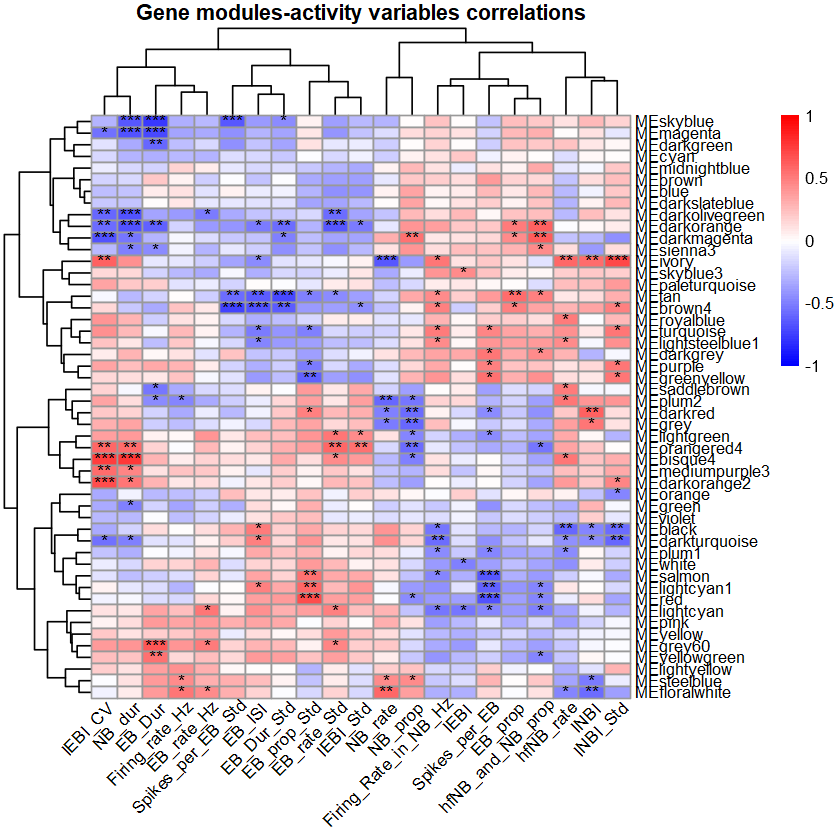

In [27]:
# --- 2. Plot heatmap ---
p<-pheatmap(est_list,
         color = colorRampPalette(c("blue", "white", "red"))(100),
         breaks = seq(-1, 1, length.out = 101),   # correlations assumed in [-1,1]
         display_numbers = sig_labels,            # overlay stars
         number_color = "black",
         fontsize_number = 10,
         cluster_rows = TRUE, cluster_cols = TRUE,
         main = "Gene modules-activity variables correlations",  angle_col = 45)

ggsave("heatmap_activity_modules.pdf",bg = "transparent",
                  width = 6,   # inches
                  height = 8,   # inches
                plot=p
            )